# Machine Learning Terapan - Submission Sistem Rekomendasi

Nama : Indri Windriasari <br>
Email: indriwindriasari2511@gmail.com

## 1 Library Import

In [1]:
# Library untuk manipulasi data dan array
import numpy as np
import pandas as pd

# Library untuk pemodelan dan evaluasi machine learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import RootMeanSquaredError

# Library untuk pengolahan teks dan kesamaan vektor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Library untuk visualisasi data
import seaborn as sns
import matplotlib.pyplot as plt

## 2 Data Understanding

### 2.1 Data Loading

Tahapan ini memuat dataset [Book Recommendation Dataset](https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset) dari Kaggle Dataset dan menampilkan informasi dari dataset.

In [2]:
# Membuat direktori baru bernama kaggle
!rm -rf ~/.kaggle && mkdir ~/.kaggle/

# Menyalin berkas kaggle.json pada direktori aktif saat ini ke direktori kaggle
!mv kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset
!kaggle datasets download -d arashnic/book-recommendation-dataset

# Ekstrak berkas zip
!unzip /content/book-recommendation-dataset.zip

mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset
License(s): CC0-1.0
 70% 17.0M/24.3M [00:00<00:00, 45.0MB/s]
100% 24.3M/24.3M [00:00<00:00, 59.5MB/s]
Archive:  /content/book-recommendation-dataset.zip
  inflating: Books.csv               
  inflating: DeepRec.png             
  inflating: Ratings.csv             
  inflating: Users.csv               
  inflating: classicRec.png          
  inflating: recsys_taxonomy2.png    


Ekstraksi berkas dilakukan dengan menggunakan perintah `!unzip`, sehingga diperoleh tiga file csv, yaitu `Books.csv`, `Ratings.csv`, dan `Users.csv`.

In [3]:
books_df = pd.read_csv('Books.csv')
ratings_df = pd.read_csv('Ratings.csv')
users_df = pd.read_csv('Users.csv')

<ipython-input-3-c79c2408daf9>:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books_df = pd.read_csv('Books.csv')


In [4]:
users_df.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [5]:
books_df.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [6]:
ratings_df.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


Dengan Library Pandas, ketiga file csv dapat dibaca dalam bentuk dataframe.

### 2.2 Kondisi Dataset & Exploratory Data Analisis (EDA)

Ukuran atau dimensi pada setiap dataset

In [7]:
print(f'Dimensi dataset users     : {users_df.shape}')
print(f'Dimensi dataset buku     : {books_df.shape}')
print(f'Dimensi dataset rating    : {ratings_df.shape}')

Dimensi dataset users     : (278858, 3)
Dimensi dataset buku     : (271360, 8)
Dimensi dataset rating    : (1149780, 3)


Exploratory Data Analysis (EDA) sebagai inversitasi awal analisa data untuk masing-masing dataframe

In [8]:
def explore(df):
  """
    Fungsi ini digunakan untuk melakukan eksplorasi awal pada dataset yang diberikan dan memberikan informasi penting tentang setiap kolom dalam DataFrame, seperti:
      - Tipe data setiap kolom.
      - Persentase nilai yang hilang di setiap kolom.
      - Jumlah nilai unik yang ada di setiap kolom.
      - Daftar nilai unik dari setiap kolom.
  """
  with pd.option_context("display.max_colwidth", 20):
    info = pd.DataFrame()
    info['Tipe Data'] = df.dtypes
    info['Persentase Missing Value'] = df.isnull().sum()*100/len(df)
    info['Jumlah Nilai Unik'] = df.apply(lambda x: len(x.unique()))
    info['Nilai Unik'] = df.apply(lambda x: x.unique())
  return info.sort_values('Tipe Data')

#### 2.2.1 Dataset Users

In [9]:
explore(users_df)

,Tipe Data,Persentase Missing Value,Jumlah Nilai Unik,Nilai Unik
User-ID,int64,0.000000,278858,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
Age,float64,39.719857,166,"[nan, 18.0, 17.0, 61.0, 26.0, 14.0, 25.0, 19.0..."
Location,object,0.000000,57339,"[nyc, new york, usa, stockton, california, usa..."


In [10]:
users_df.describe()

,User-ID,Age
count,278858.00000,168096.000000
mean,139429.50000,34.751434
std,80499.51502,14.428097
min,1.00000,0.000000
25%,69715.25000,24.000000
50%,139429.50000,32.000000
75%,209143.75000,44.000000
max,278858.00000,244.000000


Berdasarkan hasil eksplorasi terdapat missing value pada atribut `Age`. Maka, selanjutnya perlu dilakukan pemrosesan lebih lanjut pada tahap data preparation.

#### 2.2.2 Dataset Books

In [11]:
explore(books_df)

,Tipe Data,Persentase Missing Value,Jumlah Nilai Unik,Nilai Unik
ISBN,object,0.000000,271360,"[0195153448, 0002005018, 0060973129, 037415706..."
Book-Title,object,0.000000,242135,"[Classical Mythology, Clara Callan, Decision i..."
Book-Author,object,0.000737,102023,"[Mark P. O. Morford, Richard Bruce Wright, Car..."
Year-Of-Publication,object,0.000000,202,"[2002, 2001, 1991, 1999, 2000, 1993, 1996, 198..."
Publisher,object,0.000737,16808,"[Oxford University Press, HarperFlamingo Canad..."
Image-URL-S,object,0.000000,271044,[http://images.amazon.com/images/P/0195153448....
Image-URL-M,object,0.000000,271044,[http://images.amazon.com/images/P/0195153448....
Image-URL-L,object,0.001106,271042,[http://images.amazon.com/images/P/0195153448....


Berdasarkaan hasil eksplorasi terdapat missing value pada atribut `Book-Author`, `Publisher`, dan `Image-URL-L`
. Maka, selanjutnya perlu dilakukan pemrosesan lebih lanjut pada tahap data preparation.

#### 2.2.1 Dataset Ratings

In [12]:
explore(ratings_df)

,Tipe Data,Persentase Missing Value,Jumlah Nilai Unik,Nilai Unik
User-ID,int64,0.0,105283,"[276725, 276726, 276727, 276729, 276733, 27673..."
Book-Rating,int64,0.0,11,"[0, 5, 3, 6, 8, 7, 10, 9, 4, 1, 2]"
ISBN,object,0.0,340556,"[034545104X, 0155061224, 0446520802, 052165615..."


In [13]:
ratings_df.describe()

,User-ID,Book-Rating
count,1.149780e+06,1.149780e+06
mean,1.403864e+05,2.866950e+00
std,8.056228e+04,3.854184e+00
min,2.000000e+00,0.000000e+00
25%,7.034500e+04,0.000000e+00
50%,1.410100e+05,0.000000e+00
75%,2.110280e+05,7.000000e+00
max,2.788540e+05,1.000000e+01


<ipython-input-14-4d3e0b1164df>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rating_counts.index, y=rating_counts.values, palette='coolwarm')


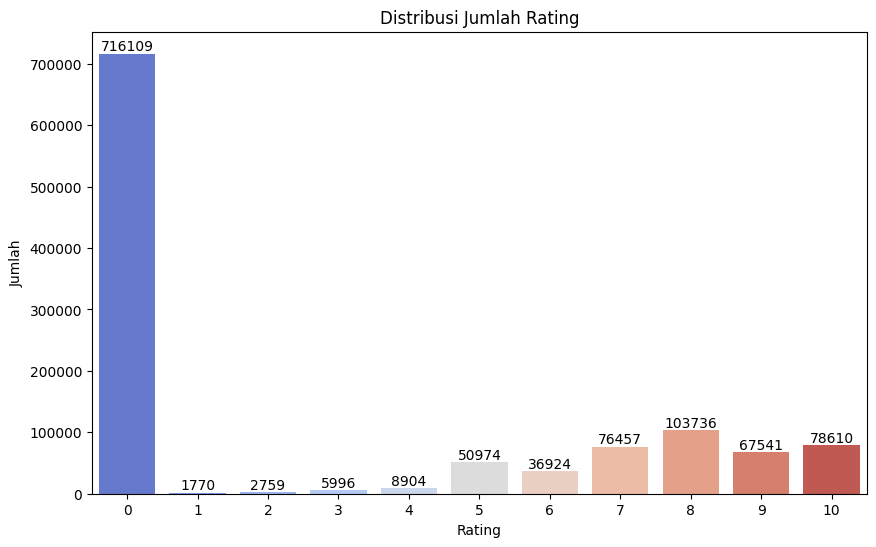

In [14]:
# Menghitung jumlah masing-masing rating
rating_counts = ratings_df['Book-Rating'].value_counts().sort_index()

# Visualisasi jumlah setiap rating
plt.figure(figsize=(10, 6))
sns.barplot(x=rating_counts.index, y=rating_counts.values, palette='coolwarm')
plt.title('Distribusi Jumlah Rating')
plt.xlabel('Rating')
plt.ylabel('Jumlah')
plt.xticks(range(len(rating_counts.index)))

# Menambahkan angka di atas grafik
for i, value in enumerate(rating_counts.values):
    plt.text(i, value + 50, str(value), ha='center', va='bottom', fontsize=10, color='black')

plt.show()


Tidak terdapat missing value pada dataset Ratings.csv. Namun, berdasarkan hasil visualisasi, rating yang terbanyak pada dataset adalah rating 0. Hal ini menunjukkan bahwa sebagian besar data tidak memiliki rating eksplisit.

Data dengan rating 0 dapat menyebabkan bias dalam analisis, sehingga perlu dipertimbangkan untuk dihapus pada tahap data preparation. Hal ini dilakukan untuk memastikan hasil analisis dan rekomendasi menjadi lebih akurat.

## 3 Data Preparation

### 3.1 Penggabungan Data

Penggabunan data ISBN dan data User untuk melihat jumlah data secara keseluruhan

In [15]:
isbn_concat = np.concatenate((
    books_df.ISBN.unique(),
    ratings_df.ISBN.unique()
))

isbn_concat = np.sort(np.unique(isbn_concat))
print(f'Jumlah Data Buku berdasarkan ISBN : {len(isbn_concat)}')

Jumlah Data Buku berdasarkan ISBN : 341765


In [16]:
ratings_df.rename(columns={
                  'User-ID'     : 'user_id'},
                  inplace=True)

users_df.rename(columns={
                  'User-ID'     : 'user_id'},
                  inplace=True)

In [17]:
user_concat = np.concatenate((
    ratings_df.user_id.unique(),
    users_df.user_id.unique()
))

user_concat = np.sort(np.unique(user_concat))
print(f'Jumlah User berdasarkan User-ID : {len(user_concat)}')

Jumlah User berdasarkan User-ID : 278858


### 3.2. Mengatasi Missing Value

Pada tahap data understanding, `users_df` memiliki data missing pada atribut `Age` dengan persentase sebesar 34.75%. Missing value tersebut akan diisi dengan nilai modus atau nilai yang paling sering muncul dalam data Age.

Pendekatan ini dipilih karena nilai modus dianggap dapat mewakili pola umum dari data yang ada. Pengisian dilakukan menggunakan fungsi `.fillna()` bersama dengan fungsi `.mode()`, sehingga `Age` akan menjadi lengkap tanpa missing value, siap untuk dianalisis lebih lanjut.

In [18]:
users_df.shape

(278858, 3)

In [19]:
users_df.isnull().sum()

,0
user_id,0
Location,0
Age,110762


In [20]:
users_df['Age'] = users_df['Age'].fillna(users_df['Age'].mode()[0])

In [21]:
users_df.isnull().sum()

,0
user_id,0
Location,0
Age,0


In [22]:
# sanity check (harus sama seperti awal karena di fill oleh mode())
users_df.shape

(278858, 3)

Pada `books.df` atribut `Book-Author`, `Publisher`, dan `Image-URL-L` memiliki missing value.

In [23]:
# cek ulang missing value
books_df.isnull().sum()

,0
ISBN,0
Book-Title,0
Book-Author,2
Year-Of-Publication,0
Publisher,2
Image-URL-S,0
Image-URL-M,0
Image-URL-L,3


Untuk menangani hal ini, data dengan nilai kosong tersebut akan dihapus menggunakan fungsi .dropna(). Hal ini karena jumlahnya yang sangat kecil tidak akan memengaruhi analisis secara signifikan. Setelah proses ini dilakukan, pengecekan ulang menunjukkan bahwa tidak ada lagi data kosong (null) pada atribut tersebut, sehingga dataset siap untuk digunakan dalam tahap analisis selanjutnya.

In [24]:
books_df = books_df.dropna()

In [25]:
books_df.isnull().sum()

,0
ISBN,0
Book-Title,0
Book-Author,0
Year-Of-Publication,0
Publisher,0
Image-URL-S,0
Image-URL-M,0
Image-URL-L,0


In [26]:
# cek ulang missing value
ratings_df.isnull().sum()

,0
user_id,0
ISBN,0
Book-Rating,0


Setelah dilakukan pengecekan terhadap dataset ratings, tidak ditemukan adanya missing value pada setiap atribut atau kolomnya. Namun, pada tahap Exploratory Data Analysis (EDA), visualisasi grafik menunjukkan bahwa sebagian besar data rating memiliki nilai 0, dengan jumlah sekitar 716.109 data.

<ipython-input-27-534bf52cb763>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rating_counts.index, y=rating_counts.values, palette='coolwarm')


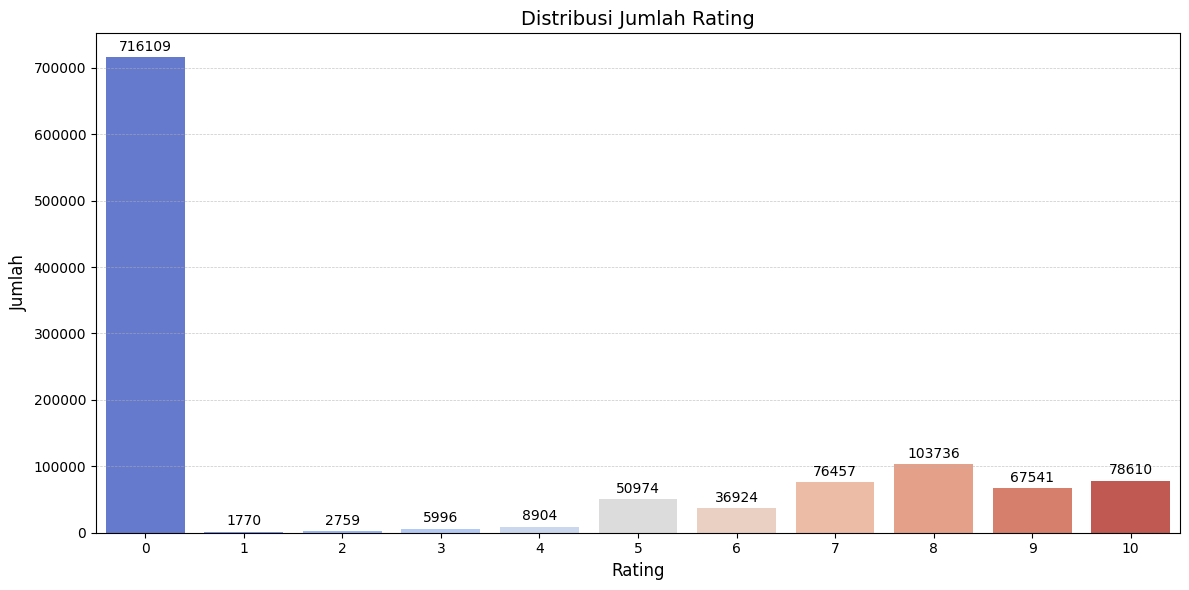

In [27]:
# Menghitung jumlah masing-masing rating
rating_counts = ratings_df['Book-Rating'].value_counts().sort_index()

# Visualisasi jumlah setiap rating
plt.figure(figsize=(12, 6))
sns.barplot(x=rating_counts.index, y=rating_counts.values, palette='coolwarm')
plt.title('Distribusi Jumlah Rating', fontsize=14)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Jumlah', fontsize=12)
plt.xticks(range(len(rating_counts.index)), fontsize=10)

# Menambahkan angka di atas grafik
for i, value in enumerate(rating_counts.values):
    plt.text(i, value + 5000, str(value), ha='center', va='bottom', fontsize=10, color='black')

plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()


Nilai rating 0 ini berpotensi menyebabkan bias pada analisis data, sehingga data dengan rating 0 akan dihapus dari dataset menggunakan fungsi filter. Data yang digunakan selanjutnya hanyalah data dengan nilai rating lebih dari 0, yaitu rating 1 hingga rating 10.

<ipython-input-28-c458fdfd2985>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rating_counts.index, y=rating_counts.values, palette='coolwarm')


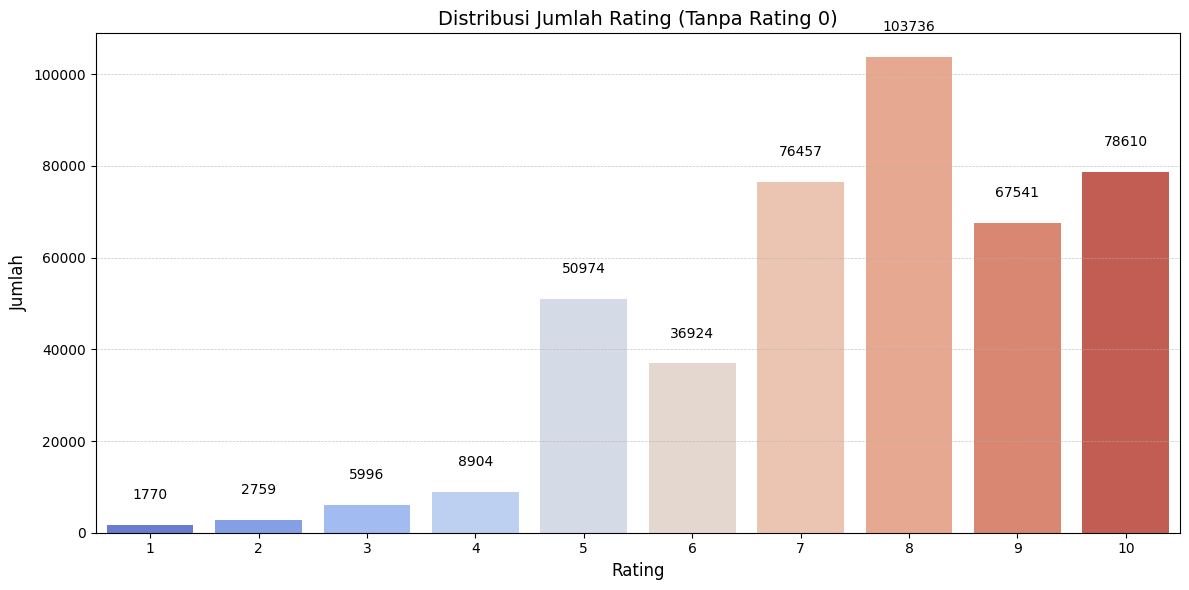

In [28]:
# Memfilter dataset untuk rating 1 hingga 10
ratings_df = ratings_df[ratings_df['Book-Rating'] > 0]

# Menghitung jumlah masing-masing rating
rating_counts = ratings_df['Book-Rating'].value_counts().sort_index()

# Visualisasi jumlah setiap rating
plt.figure(figsize=(12, 6))
sns.barplot(x=rating_counts.index, y=rating_counts.values, palette='coolwarm')
plt.title('Distribusi Jumlah Rating (Tanpa Rating 0)', fontsize=14)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Jumlah', fontsize=12)
plt.xticks(range(len(rating_counts.index)), fontsize=10)

# Menambahkan angka di atas grafik
for i, value in enumerate(rating_counts.values):
    plt.text(i, value + 5000, str(value), ha='center', va='bottom', fontsize=10, color='black')

plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()


### 3.3 Mengatasi Data Duplikat

In [29]:
# Pengecekan duplikat pada masing-masing dataframe
duplicate_books = books_df.duplicated().sum()
duplicate_ratings = ratings_df.duplicated().sum()
duplicate_users = users_df.duplicated().sum()

# Menampilkan hasil
print(f"Jumlah data duplikat pada Books  : {duplicate_books}")
print(f"Jumlah data duplikat pada Ratings: {duplicate_ratings}")
print(f"Jumlah data duplikat pada Users  : {duplicate_users}")

Jumlah data duplikat pada Books  : 0
Jumlah data duplikat pada Ratings: 0
Jumlah data duplikat pada Users  : 0


Berdasarkan hasil pengecekan data duplikat pada masing-masing dataframe:

- Books: Tidak ditemukan data duplikat dalam tabel Books. Hal ini berarti setiap buku dalam dataset unik, baik dari segi ISBN maupun atribut lainnya.
- Ratings: Tidak terdapat data rating yang duplikat. Setiap kombinasi user dan buku memiliki rating yang unik atau tidak terduplikasi.
- Users: Tidak ditemukan data user yang duplikat. Setiap user dalam dataset memiliki ID yang unik dan informasi demografi yang tidak saling tumpang tindih.

### 3.4 Merge Data Rating dengan Data Buku

Merge data dilakukan dari hasil filter rating tanpa rating nol pada tahapan sebelumnya dengan data buku.

Sehingga dataframe `books_ratings_merge` akan berisi informasi gabungan dari kedua dataframe. Isinya akan mencakup data rating buku dari hasil filter`ratings_df` dan informasi buku dari `books_df`, di mana setiap baris menunjukkan rating untuk buku tertentu yang memiliki ISBN yang sama.

In [30]:
books_ratings_merge = pd.merge(ratings_df, books_df, on=['ISBN'])
books_ratings_merge.head(5)

,user_id,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,276726,0155061224,5,Rites of Passage,Judith Rae,2001,Heinle,http://images.amazon.com/images/P/0155061224.0...,http://images.amazon.com/images/P/0155061224.0...,http://images.amazon.com/images/P/0155061224.0...
1,276729,052165615X,3,Help!: Level 1,Philip Prowse,1999,Cambridge University Press,http://images.amazon.com/images/P/052165615X.0...,http://images.amazon.com/images/P/052165615X.0...,http://images.amazon.com/images/P/052165615X.0...
2,276729,0521795028,6,The Amsterdam Connection : Level 4 (Cambridge ...,Sue Leather,2001,Cambridge University Press,http://images.amazon.com/images/P/0521795028.0...,http://images.amazon.com/images/P/0521795028.0...,http://images.amazon.com/images/P/0521795028.0...
3,276744,038550120X,7,A Painted House,JOHN GRISHAM,2001,Doubleday,http://images.amazon.com/images/P/038550120X.0...,http://images.amazon.com/images/P/038550120X.0...,http://images.amazon.com/images/P/038550120X.0...
4,276747,0060517794,9,Little Altars Everywhere,Rebecca Wells,2003,HarperTorch,http://images.amazon.com/images/P/0060517794.0...,http://images.amazon.com/images/P/0060517794.0...,http://images.amazon.com/images/P/0060517794.0...


## 4 Modelling & Result

Berdasarkan pemahaman data sebelumnya, data buku, rating, dan pengguna cukup besar, mencapai ratusan hingga jutaan entri. Hal ini berpotensi meningkatkan biaya pemodelan, seperti waktu pemrosesan dan penggunaan resource. Oleh karena itu, untuk efisiensi, data yang digunakan akan dibatasi pada 10.000 untuk baris data buku dan 5.000 untuk baris data rating.

In [31]:
books_df   = books_df[:10000]
ratings_df = ratings_df[:5000]

In [32]:
books_df.shape

(10000, 8)

In [33]:
ratings_df.shape

(5000, 3)

### 4.1 Content-based

#### 4.1.1 TF-IDF Vectorizer

In [34]:
books_df.rename(columns={ 'Book-Author'     : 'book_author'},
                inplace=True)

# inisialisasi TfidfVectorizer
tfidf = TfidfVectorizer()

# melakukan perhitungan idf pada data book_author
tfidf.fit(books_df.book_author)

<ipython-input-34-905d9caa7644>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  books_df.rename(columns={ 'Book-Author'     : 'book_author'},


TfidfVectorizer()

In [35]:
matrix_tfidf = tfidf.fit_transform(books_df.book_author)

In [36]:
# melihat ukuran matriks tfidf
matrix_tfidf.shape

(10000, 5575)

In [37]:
# mengubah ke bentuk matriks
matrix_tfidf.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [38]:
books_df.rename(columns={ 'Book-Title'     : 'book_title'},
                inplace=True)

pd.DataFrame( matrix_tfidf.todense(),
              columns = tfidf.get_feature_names_out(),
              index   = books_df.book_title
).sample(20, axis=1).sample(5, axis=0)

,stã,edward,bellacera,duane,bullard,tey,anatolian,meier,padriac,arriaga,marten,beattie,dostoevsky,goldin,stephan,kynaston,wilcox,keene,rochon,per
book_title,,,,,,,,,,,,,,,,,,,,
"The Diary of Jack the Ripper/the Discovery, the Investigation, the Debate",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
The Final Faberge,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Whitsun Weddings,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A Samba for Sherlock,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A Queer Reader,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### 4.1.2 Cosine Similarity

In [39]:
cosine_sim = cosine_similarity(matrix_tfidf)
cosine_sim

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [40]:
cosine_sim_df = pd.DataFrame(
    cosine_sim,
    columns = books_df.book_title,
    index   = books_df.book_title
)

print(f'Cosine Similarity Shape : {cosine_sim_df.shape}')

Cosine Similarity Shape : (10000, 10000)


In [41]:
# melihat similarity matriks
cosine_sim_df.sample(20, axis=1).sample(5, axis=0)

book_title,The Death of Tecumseh (Adventures in Canadian History : the Battles of the War of 1812),La Ballade de l'impossible,The Lion's Game,Little Girl Lost,The Deptford Trilogy (King Penguin S.),Alias Grace,Cheaper by the Dozen,Warm Worlds and Otherwise,Lady in Green/Minor Indiscretions (Signet Regency Romance),"The Secret Diary of Adrian Mole, Aged 13 3/4",The Lovely Bones: A Novel,Turning Thirty,The Accidental Tourist,Manhattan Memoir,If the Buddha Married: Creating Enduring Relationships on a Spiritual Path,"The Professor and the Madman: A Tale of Murder, Insanity, and the Making of The Oxford English Dictionary",Verdict in Blood (Joanne Kilbourn Mysteries (Paperback)),Embraced by the Light,Blindness (Harvest Book),Rising Tides
book_title,,,,,,,,,,,,,,,,,,,,
"In the Balance (Worldwar Series, Volume 1)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Glorious Angel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Having Everything,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Little Altars Everywhere: A Novel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
The Seal Wife : A Novel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### 4.1.3 Recommendation Result

In [42]:
def book_recommendations(book_title, similarity_data=cosine_sim_df, items=books_df[['book_title', 'book_author']], k=10):

    # mengambil data dengan menggunakan argpartition untuk melakukanpartisi secara tidak langsung sepanjang sumbu
    index = similarity_data.loc[:,book_title].to_numpy().argpartition(range(-1, -k, -1))

    # mengambil data dengan nilai similarity terbesar
    closest = similarity_data.columns[index[-1:-(k+2):-1]]

    # menghapus judul buku  yang dicari agar tidak muncul pada daftar rekomendasi
    closest = closest.drop(book_title, errors='ignore')

    return pd.DataFrame(closest).merge(items).head(k)

In [43]:
targeted_book = 'Devoted'
books_df[books_df.book_title.eq(targeted_book)]

,ISBN,book_title,book_author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
6159,0451403967,Devoted,Alice Borchardt,1996,Signet Book,http://images.amazon.com/images/P/0451403967.0...,http://images.amazon.com/images/P/0451403967.0...,http://images.amazon.com/images/P/0451403967.0...


In [44]:
# mendapatkan rekomendasi buku yang mirip
book_recommendations(targeted_book).drop_duplicates()

,book_title,book_author
0,The Wolf King,Alice Borchardt
1,Beguiled,Alice Borchardt
2,Superior Women,Alice Adams
3,Turtle Moon,Alice Hoffman
5,Green Angel,Alice Hoffman
6,The Temple of My Familiar,Alice Walker
9,Here on Earth (Oprah's Book Club),Alice Hoffman


In [45]:
## 1. Content-Based Evaluation
def evaluate_content_based(books_df, cosine_sim_df, k=10, sample_size=278):
    """
    Evaluasi untuk content-based filtering
    """
    results = {
        'precision': [],
        'recall': [],
        'f1': [],
        'coverage': set()
    }

    # Batasi k agar tidak melebihi jumlah buku yang tersedia
    k = min(k, len(books_df) - 1)

    # Ambil sample untuk evaluasi
    sample_size = min(sample_size, len(books_df))
    sample_books = books_df.sample(n=sample_size, random_state=42)

    successful_evaluations = 0

    for _, book in sample_books.iterrows():
        try:
            # Dapatkan rekomendasi
            recommendations = book_recommendations(
                book['book_title'],
                similarity_data=cosine_sim_df,
                items=books_df[['book_title', 'book_author']],
                k=k
            )

            if len(recommendations) > 0:
                # Hitung metrics
                relevant_recs = len(recommendations[recommendations['book_author'] == book['book_author']])
                total_relevant = len(books_df[books_df['book_author'] == book['book_author']]) - 1

                precision = relevant_recs / k
                recall = relevant_recs / total_relevant if total_relevant > 0 else 0
                f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

                results['precision'].append(precision)
                results['recall'].append(recall)
                results['f1'].append(f1)
                results['coverage'].update(recommendations['book_title'])

                successful_evaluations += 1

        except Exception as e:
            continue

    if successful_evaluations > 0:
        final_metrics = {
            'precision': np.mean(results['precision']),
            'recall': np.mean(results['recall']),
            'f1_score': np.mean(results['f1']),
            'coverage': len(results['coverage']) / len(books_df),
            'samples_evaluated': successful_evaluations
        }
    else:
        final_metrics = {
            'precision': 0,
            'recall': 0,
            'f1_score': 0,
            'coverage': 0,
            'samples_evaluated': 0
        }

    return final_metrics

# Evaluasi Content-Based
metrics_cb = evaluate_content_based(books_df, cosine_sim_df, k=5)

In [46]:
# Print detailed results
print("\nContent-Based Filtering Metrics:")
print("================================")
print(f"Precision@10 : {metrics_cb['precision']:.3f}")
print(f"Recall      : {metrics_cb['recall']:.3f}")
print(f"F1-Score    : {metrics_cb['f1_score']:.3f}")
print(f"Samples     : {metrics_cb['samples_evaluated']}")


Content-Based Filtering Metrics:
Precision@10 : 0.339
Recall      : 0.394
F1-Score    : 0.294
Coverage    : 0.089
Samples     : 257


### 4.2 Collaborative Filtering

#### 4.2.1 Penyandian (encoding) Fitur

In [47]:
# mengubah User-ID  menjadi list tanpa nilai yang sama
user_ids = ratings_df.user_id.unique().tolist()

# melakukan encoding User-ID
user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}

# melakukan encoding angka ke User-ID
user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}

print('List User-ID            : ', user_ids)
print('Encoded User-ID         : ', user_to_user_encoded)
print('Encoded angka ke User-ID: ', user_encoded_to_user)

List User-ID            :  [276726, 276729, 276736, 276737, 276744, 276745, 276747, 276748, 276751, 276754, 276755, 276760, 276762, 276768, 276772, 276774, 276780, 276786, 276788, 276796, 276798, 276800, 276804, 276808, 276811, 276812, 276813, 276814, 276820, 276822, 276827, 276828, 276830, 276832, 276835, 276837, 276842, 276847, 276848, 276850, 276853, 276854, 276857, 276859, 276861, 276862, 276863, 276866, 276870, 276872, 276873, 276875, 276878, 276879, 276884, 276887, 276888, 276896, 276904, 276905, 276911, 276912, 276915, 276916, 276925, 276927, 276928, 276929, 276934, 276936, 276939, 276949, 276953, 276954, 276957, 276959, 276964, 276965, 276984, 276986, 276988, 276990, 276992, 276994, 276998, 277002, 277007, 277009, 277010, 277012, 277018, 277023, 277028, 277031, 277032, 277036, 277042, 277048, 277051, 277052, 277053, 277056, 277058, 277065, 277072, 277074, 277079, 277085, 277087, 277090, 277094, 277096, 277107, 277109, 277116, 277124, 277128, 277129, 277134, 277135, 277139, 2771

In [48]:
# mengubah ISBN  menjadi list tanpa nilai yang sama
book_ids = ratings_df.ISBN.unique().tolist()

# melakukan encoding ISBN
book_to_book_encoded = {x: i for i, x in enumerate(book_ids)}

# melakukan encoding angka ke ISBN
book_encoded_to_book = {i: x for i, x in enumerate(book_ids)}

print('List ISBN               : ', book_ids)
print('Encoded ISBN            : ', book_to_book_encoded)
print('Encoded angka ke ISBN   : ', book_encoded_to_book)

List ISBN               :  ['0155061224', '052165615X', '0521795028', '3257224281', '0600570967', '038550120X', '342310538', '0060517794', '0671537458', '0679776818', '0943066433', '1885408226', '0747558167', '3596218098', '0684867621', '0451166892', '8440682697', '0380711524', '3453092007', '3453213025', 'N3453124715', '9057868059', '0553572369', '3499230933', '3596151465', '3442136644', '8484330478', '8484332039', '2864322102', '8437606322', '8466300821', '8478442588', '0345443683', '043935806X', '055310666X', '0330332775', '0006379702', '3442131340', '3548603203', '1562827898', '0440498058', '0395547032', '0440414121', '8879839993', '8423996565', '8426449476', '8426449573', '8478884831', '8478885218', '8478885463', '8478886044', '0091830893', '0586207414', '0812571029', '0140260498', '0060096195', '0141310340', '0142302198', '0156006065', '0375821813', '038076041X', '0439401399', '0552546933', '0689804458', '0699854289', '0786812508', '0786817070', '0805057706', '1551925060', '15732

Mapping User-ID dan ISBN ke dataframe

In [49]:
# mapping User-ID ke dataframe user
ratings_df['user'] = ratings_df.user_id.map(user_to_user_encoded)
# mapping ISBN ke dataframe buku
ratings_df['book'] = ratings_df.ISBN.map(book_to_book_encoded)

Mengecek Jumlah

In [50]:
num_users = len(user_encoded_to_user)
num_books = len(book_encoded_to_book)
print('Jumlah User: ', num_users)
print('Jumlah Buku: ', num_books)

ratings_df.rename(columns={ 'Book-Rating'     : 'book_rating'},
                inplace=True)

min_ratings = min(ratings_df.book_rating)
max_ratings = max(ratings_df.book_rating)
print('Minimal Rating: ', min_ratings)
print('Maksimal Rating: ', max_ratings)

Jumlah User:  1204
Jumlah Buku:  4565
Minimal Rating:  1
Maksimal Rating:  10


In [51]:
# mengacak dataset
ratings_df = ratings_df.sample(frac=1, random_state=42)
ratings_df

,user_id,ISBN,book_rating,user,book
3461,278054,0060501804,8,393,1453
9882,190,0002740230,7,679,2443
10035,243,155874262X,5,692,2232
2524,277639,042516098X,5,263,1035
1603,277427,0425047962,8,200,695
...,...,...,...,...,...
13602,1838,0061012289,9,1118,4050
945,277157,0425183181,5,122,461
11159,643,0140482202,8,793,2898
12432,1211,0099771519,9,953,3252


#### 4.2.2 Data Splitting

Dataset dibagi dengan rasio 80:20. Hal ini berarti bahwa 80% dari data dgunakan untuk pelatihan model (training) dan 20% untuk uji.

In [52]:
# membuat variabel yang mencocokan data user dengan data buku
x = ratings_df[['user', 'book']].values

# membuat variabel targer (y) untuk membuat rating dari hasil
y = ratings_df['book_rating'].apply(lambda x: (x-min_ratings) / (max_ratings-min_ratings)).values

# membagi dataset menjadi 80:20.
train_indices = int(0.8 * ratings_df.shape[0])

x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

In [53]:
print(x, y)

[[ 393 1453]
 [ 679 2443]
 [ 692 2232]
 ...
 [ 793 2898]
 [ 953 3252]
 [ 215  846]] [0.77777778 0.66666667 0.44444444 ... 0.77777778 0.88888889 0.66666667]


#### 4.2.3 Training Model

In [54]:
class RecommenderNet(tf.keras.Model):
    def __init__(self, num_users, num_books, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_books = num_books
        self.embedding_size = embedding_size

        self.user_embedding = layers.Embedding( # layer embedding user
            num_users,
            embedding_size,
            embeddings_initializer = 'he_normal',
            embeddings_regularizer = keras.regularizers.l2(1e-6))
        self.user_bias      = layers.Embedding(num_users, 1) # layer embedding user bias

        self.book_embedding = layers.Embedding( # layer embedding buku
            num_books,
            embedding_size,
            embeddings_initializer = 'he_normal',
            embeddings_regularizer = keras.regularizers.l2(1e-6))
        self.book_bias = layers.Embedding(num_books, 1) # layer embedding buku bias

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:,0])  # memanggil layer embedding 1
        user_bias   = self.user_bias(inputs[:, 0])      # memanggil layer embedding 2
        book_vector = self.book_embedding(inputs[:, 1]) # memanggil layer embedding 3
        book_bias   = self.book_bias(inputs[:, 1])      # memanggil layer embedding 4

        dot_user_book = tf.tensordot(user_vector, book_vector, 2)
        x = dot_user_book + user_bias + book_bias

        return tf.nn.sigmoid(x)

In [55]:
model = RecommenderNet(num_users, num_books, 50) # inisialisasi model

model.compile(
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    loss      = tf.keras.losses.BinaryCrossentropy(),
    metrics   = [RootMeanSquaredError()]
)

In [56]:
# training model
history = model.fit(
    x               = x_train,
    y               = y_train,
    batch_size      = 8,
    epochs          = 100,
    validation_data = (x_val, y_val),
)

Epoch 1/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.6895 - root_mean_squared_error: 0.3091 - val_loss: 0.6762 - val_root_mean_squared_error: 0.3016
Epoch 2/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6271 - root_mean_squared_error: 0.2485 - val_loss: 0.6659 - val_root_mean_squared_error: 0.2929
Epoch 3/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.5765 - root_mean_squared_error: 0.1978 - val_loss: 0.6657 - val_root_mean_squared_error: 0.2927
Epoch 4/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5706 - root_mean_squared_error: 0.1890 - val_loss: 0.6630 - val_root_mean_squared_error: 0.2904
Epoch 5/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5569 - root_mean_squared_error: 0.1851 - val_loss: 0.6608 - val_root_mean_squared_error: 0.2885
Epoch 6/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5510 - root_mean_squared_error: 0.1790 - val_loss: 0.6587 - val_root_mean_squared_error: 0.2867
Epoch 7/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2m

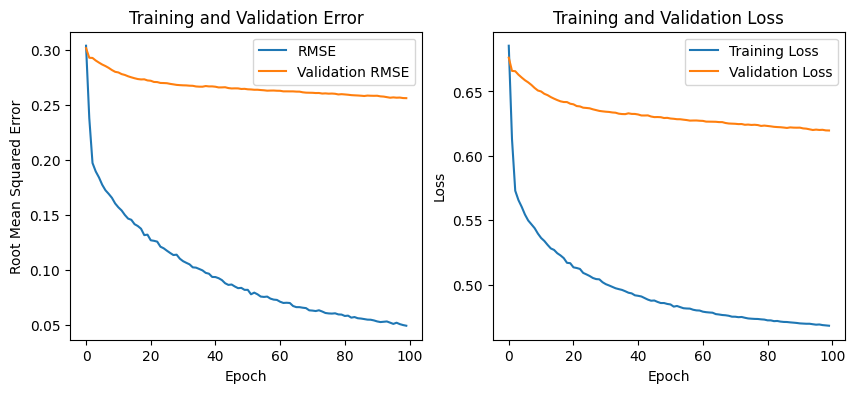

In [57]:
rmse     = history.history['root_mean_squared_error']
val_rmse = history.history['val_root_mean_squared_error']

plt.figure(figsize = (10, 4))

plt.subplot(1, 2, 1)
plt.plot(rmse,     label='RMSE')
plt.plot(val_rmse, label='Validation RMSE')
plt.title('Training and Validation Error')
plt.xlabel('Epoch')
plt.ylabel('Root Mean Squared Error')
plt.legend(loc='upper right')

loss     = history.history['loss']
val_loss = history.history['val_loss']
plt.subplot(1, 2, 2)
plt.plot(loss,     label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.show()

#### 4.2.4 Recommendation Result

In [58]:
# data_book   = books_df
# data_rating = ratings_df

In [59]:
datasetBook   = books_df
datasetRating = ratings_df

In [60]:
userId      = datasetRating.user_id.sample(1).iloc[0]
readedBooks = datasetRating[datasetRating.user_id == userId]

notReadedBooks = datasetBook[~datasetBook['ISBN'].isin(readedBooks.ISBN.values)]['ISBN']
notReadedBooks = list(
    set(notReadedBooks).intersection(set(book_to_book_encoded.keys()))
)

notReadedBooks = [[book_to_book_encoded.get(x)] for x in notReadedBooks]
userEncoder    = user_to_user_encoded.get(userId)
userBookArray = np.hstack(
    ([[userEncoder]] * len(notReadedBooks), notReadedBooks)
)

In [61]:
ratings = model.predict(userBookArray).flatten()

topRatingsIndices   = ratings.argsort()[-10:][::-1]
recommendedBookIds = [
    book_encoded_to_book.get(notReadedBooks[x][0]) for x in topRatingsIndices
]

print('Showing recommendations for users: {}'.format(userId))
print('=====' * 8)
print('Book with high ratings from user')
print('-----' * 8)

topBookUser = (
    readedBooks.sort_values(
        by = 'book_rating',
        ascending=False
    )
    .head(5)
    .ISBN.values
)

bookDfRows = datasetBook[datasetBook['ISBN'].isin(topBookUser)]
for row in bookDfRows.itertuples():
    print(row.book_title, ':', row.book_author)

print('=====' * 8)
print('Top 10 Books Recommendation')
print('-----' * 8)

recommended_book = datasetBook[datasetBook['ISBN'].isin(recommendedBookIds)]
for row in recommended_book.itertuples():
    print(row.book_title, ':', row.book_author)

61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Showing recommendations for users: 805
Book with high ratings from user
----------------------------------------
Angle of Repose (Contemporary American Fiction) : Wallace Stegner
White Noise (Contemporary American Fiction) : Don DeLillo
Invisible Man : Ralph Ellison
Where the Sidewalk Ends : Poems and Drawings : Shel Silverstein
Writing Down the Bones : NATALIE GOLDBERG
Top 10 Books Recommendation
----------------------------------------
To Kill a Mockingbird : Harper Lee
The Robber Bride : Margaret Atwood
The Bean Trees : Barbara Kingsolver
The Demon-Haunted World: Science As a Candle in the Dark : Carl Sagan
The Grapes of Wrath: John Steinbeck Centennial Edition (1902-2002) : John Steinbeck
The Dragon Reborn (The Wheel of Time, Book 3) : Robert Jordan
Kushiel's Chosen (Kushiel's Legacy) : Jacqueline Carey
The Message (Animorphs , No 4) : K. A. Applegate
The Visitor (Animorphs, No 2) : K. A. Applegate
Sons of Entropy  (Buffy the Vampire Slayer: T